Imports

In [0]:
import pandas as pd
import keras
import numpy as np
import cv2

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
from zipfile import ZipFile


In [0]:
def unzip(src, dst):
  with ZipFile(src, 'r') as zipObj:
    zipObj.extractall(dst)

In [0]:
import os
import pandas as pd

def get_files(dir):
    out_files = []
    for root, subdirs, files in os.walk(dir):
        for file in files:
            path = os.path.join(root, file)
            out_files.append(path)
    out_files.sort()
    return out_files


In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath('/content/drive/My Drive/Mask_RCNN')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [0]:

def build_mask(width, height, annot):
  count = len(annot)
  if (count == 0):
    return np.zeros((width, height, 1)).astype(np.bool), np.zeros((1, ), dtype=np.int32)
  class_ids = np.zeros((count,), dtype=np.int32)
  mask = np.zeros((width, height, count), dtype=np.uint8)
  for i in range(count):
    an = annot.iloc[i]
    copy = mask[:, :, i].copy()
    cv2.rectangle(copy, (an[2], an[3]), (an[2] + an[4], an[3] + an[5]), 1, -1)
    mask[:, :, i] = copy
    class_ids[i] = an[6] + 1
  return mask.astype(np.bool), class_ids

class ZooDataset(utils.Dataset):
  def __init__(self, frames, annotations):
    super().__init__(self)

    self.add_class('wildlife', 1, 'animal')
    self.add_class('wildlife', 2, 'human')
    
    first_image = cv2.imread(frames[0])
    shape = first_image.shape[:-1]
    self.width = shape[0]
    self.height = shape[1]

    self.frames = frames
    self.annotations = annotations

    for i in range(len(frames)):
      self.add_image("wildlife", image_id=i, path=None,
                     width=self.width, height=self.height)

  def image_reference(self, image_id):
    return self.frames[i].split('/')[-2:]

  def load_image(self, image_id):
    return cv2.imread(self.frames[image_id])

  def load_mask(self, image_id):
    annot = self.annotations[self.annotations[0] == image_id]
    return build_mask(self.width, self.height, annot)


In [9]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "wildlife"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 35

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)







Re-starting from epoch 17


In [0]:
def top_files(dir):
  files = [i for i in next(os.walk(dir))]
  files = [os.path.join(dir, i) for i in files[1] if not i.startswith('__')]
  files.sort()
  return files



In [0]:
videos_dir = '/content/drive/My Drive/zoo'
videos = top_files(videos_dir)

In [0]:
annot_dir = '/content/drive/My Drive/zoo_annot'
annots = get_files(annot_dir)

In [0]:
video_len = [len(get_files(video)) for video in videos]
video_len.sort()
size = video_len[0]

In [17]:
ratio = 0.1

for i in range(3, len(videos)):
  
  frames = get_files(videos[i])[:size]
  annotations = pd.read_csv(annots[i], header=None)
  val_size = int(ratio * len(frames))
  train_data = frames[:-val_size]
  val_data = frames[-val_size:]
  train = ZooDataset(train_data, annotations)
  val = ZooDataset(val_data, annotations)
  train.prepare()
  val.prepare()

  model.train(train, val, 
            learning_rate=0.001, 
            epochs=18 + (i - 3) * 5, layers='heads')
  print('video ', i, ' trained')


Starting at epoch 17. LR=0.001

Checkpoint Path: /content/drive/My Drive/Mask_RCNN/logs/wildlife20191117T0834/mask_rcnn_wildlife_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 18/18
35/35 [==============================] - 35s 1s/step - loss: 1.4744 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5944 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.4531 - mrcnn_mask_loss: 0.3599 - val_loss: 0.3899 - val_rpn_class_loss: 0.0228 - val_rpn_bbox_loss: 0.3669 - val_mrcnn_class_loss: 2.0383e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00

video  3  trained

Starting at epoch 18. LR=0.001

Checkpoint Path: /content/drive/My Drive/Mask_RCNN/logs/wildlife20191117T0834/mask_rcnn_wildlife_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistribute

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 19/23
34/35 [============================>.] - ETA: 0s - loss: 1.2936 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4649 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.4106

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multipr

KeyboardInterrupt: ignored

In [0]:
last_video = get_files(videos[-1])
last_annots = pd.read_csv(annots[-1], header=None)

In [0]:
ratio = 0.1
val_size = int(ratio * len(last_video))
train_data = last_video[:-val_size]
val_data = last_video[-val_size:]
train = ZooDataset(train_data, last_annots)
val = ZooDataset(val_data, last_annots)
train.prepare()
val.prepare()

model.train(train, val, 
          learning_rate=0.001, 
          epochs=10, layers='heads')

In [18]:

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/Mask_RCNN/logs/wildlife20191117T0834/mask_rcnn_wildlife_0018.h5
Re-starting from epoch 18


In [19]:
videos

['/content/drive/My Drive/zoo/0000000062_0000000000',
 '/content/drive/My Drive/zoo/0000000067_0000000005',
 '/content/drive/My Drive/zoo/0000000067_0000000012',
 '/content/drive/My Drive/zoo/0000000067_0000000014',
 '/content/drive/My Drive/zoo/0000000067_0000000015',
 '/content/drive/My Drive/zoo/0000000067_0000000019',
 '/content/drive/My Drive/zoo/0000000067_0000000024',
 '/content/drive/My Drive/zoo/0000000067_0000000025',
 '/content/drive/My Drive/zoo/0000000067_0000000026',
 '/content/drive/My Drive/zoo/0000000067_0000000027',
 '/content/drive/My Drive/zoo/0000000067_0000000028',
 '/content/drive/My Drive/zoo/0000000067_0000000029',
 '/content/drive/My Drive/zoo/0000000067_0000000031',
 '/content/drive/My Drive/zoo/0000000067_0000000032',
 '/content/drive/My Drive/zoo/0000000067_0000000040',
 '/content/drive/My Drive/zoo/0000000067_0000000041',
 '/content/drive/My Drive/zoo/0000000067_0000000045',
 '/content/drive/My Drive/zoo/0000000067_0000000046',
 '/content/drive/My Drive/zo

In [20]:
frames = get_files(videos[-1])
annotations = pd.read_csv(annots[-1], header=None)



result = model.detect([cv2.imread(frames[-2002])], verbose=1)
result

Processing 1 images
image                    shape: (321, 700, 3)         min:   96.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


[{'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1], dtype=int32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False

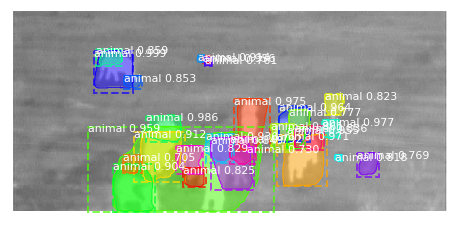

In [21]:

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

res = result[0]

visualize.display_instances(cv2.imread(frames[-2002]), res['rois'], res['masks'], res['class_ids'], 
                            ['none','animal', 'human'], res['scores'], ax=get_ax())

In [0]:
packed = []
def pack_predict(predictions, index):
  pred = predictions[0]
  rois = pred['rois']
  ids = pred['class_ids']
  res = []
  for i in range(len(rois)):
    roi = rois[i]
    class_id = ids[i]
    packed.append([index, i, roi[0], roi[1], roi[2] - roi[0], roi[3] - roi[1], ids[i] - 1, -1, 0, 0])

In [40]:
packed

[]

In [0]:
unzip('/content/drive/My Drive/zoohackathon_test.zip', '/content/drive/My Drive/zoo_test')

In [0]:
test_dir = '/content/drive/My Drive/zoo'
out_dir = '/content/drive/My Drive/pred'
videos = top_files(test_dir)
for video in videos:
  frames_path = get_files(video)
  i = 0
  packed = []
  for frame_path in frames_path:
    frame = cv2.imread(frame_path)
    predict = model.detect([frame])
    pack_predict(predict, i)
    i += 1
    print('frme ', i ,' packed')
  preds = np.array(packed)
  print(os.path.join(out_dir, video.split('/')[-1:]), ' packed')
  numpy.savetxt(os.path.join(out_dir, video.split('/')[-1:]), preds, delimiter=",")

frme  1  packed
frme  2  packed
frme  3  packed
frme  4  packed
frme  5  packed
frme  6  packed
frme  7  packed
frme  8  packed
frme  9  packed
frme  10  packed
frme  11  packed
frme  12  packed
frme  13  packed
frme  14  packed
frme  15  packed
frme  16  packed
frme  17  packed
frme  18  packed
frme  19  packed
frme  20  packed
frme  21  packed
frme  22  packed
frme  23  packed
frme  24  packed
frme  25  packed
frme  26  packed
frme  27  packed
frme  28  packed
frme  29  packed
frme  30  packed
frme  31  packed
frme  32  packed
frme  33  packed
frme  34  packed
frme  35  packed
frme  36  packed
frme  37  packed
frme  38  packed
frme  39  packed
frme  40  packed
frme  41  packed
frme  42  packed
frme  43  packed
frme  44  packed
frme  45  packed
frme  46  packed
frme  47  packed
frme  48  packed
frme  49  packed
frme  50  packed
frme  51  packed
frme  52  packed
frme  53  packed
frme  54  packed
frme  55  packed
frme  56  packed
frme  57  packed
frme  58  packed
frme  59  packed
frme  

1
